Chan, S. C. Y., Ho, Y.-W., & Karczmarski, L. (2024). Reproductive dynamics of an inshore delphinid reflect demographic consequences of large-scale coastal constructions. _Biological Conservation_, 297, 110690.

[![DOI](https://img.shields.io/badge/10.1016%2Fj.biocon.2024.110690-logo?style=flat-square&label=DOI&labelColor=a9bcc2&color=edf1f0)](https://doi.org/10.1016/j.biocon.2024.110690) [![Code](https://img.shields.io/badge/Code-logo?style=flat-square&logo=Github&color=000000)](https://github.com/YuenWaHo/sousa_repro_dynamics)

Analytical code prepared by [Yuen-Wa HO](https://github.com/YuenWaHo)

In [5]:
import sys
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

print(f"Python version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print('pymc version:', pm.__version__)
print('arviz version:', az.__version__)
print('lifelines version:', lifelines.__version__)

Python version: 3.10.14
pymc version: 4.1.4
arviz version: 0.12.1
lifelines version: 0.29.0


# Crude Birth Rate

In [ ]:
number_of_individuals = np.array([])
number_of_births = np.array([])

with pm.Model() as model_CBR:
    # Hyperpriors for population-level parameters
    alpha_pop = pm.Gamma('alpha_pop', 1, 1)
    beta_pop = pm.Gamma('beta_pop', 1, 1)

    p = pm.Beta('p', alpha=alpha_pop, beta=beta_pop, shape=len(number_of_individuals))
    p_mean = pm.Deterministic('p_mean', p.mean())
    # Likelihood
    y = pm.Binomial('y', n=number_of_individuals, p=p, observed=number_of_births)  
    trace_CBR = pm.sample(100000, tune=5000, n_init=10000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_pop, beta_pop, p]


Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 173 seconds.
/opt/homebrew/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [6]:
with model_CBR:
    CBR_summary = pm.summary(trace_CBR, hdi_prob=0.95)

In [7]:
CBR_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_pop,0.437,0.165,0.151,0.764,0.000,0.000,425921.0,311148.0,1.0
beta_pop,3.799,1.943,0.656,7.638,0.003,0.002,464374.0,301118.0,1.0
p[0],0.055,0.017,0.023,0.089,0.000,0.000,604291.0,289660.0,1.0
p[1],0.041,0.014,0.016,0.068,0.000,0.000,577027.0,280657.0,1.0
p[2],0.047,0.014,0.021,0.076,0.000,0.000,584416.0,283465.0,1.0
p[3],0.042,0.012,0.020,0.067,0.000,0.000,606598.0,283622.0,1.0
p[4],0.035,0.011,0.016,0.056,0.000,0.000,592532.0,279075.0,1.0
p[5],0.019,0.009,0.004,0.036,0.000,0.000,563279.0,276616.0,1.0
p[6],0.011,0.007,0.001,0.026,0.000,0.000,521285.0,252471.0,1.0
p[7],0.009,0.007,0.000,0.023,0.000,0.000,438567.0,224452.0,1.0


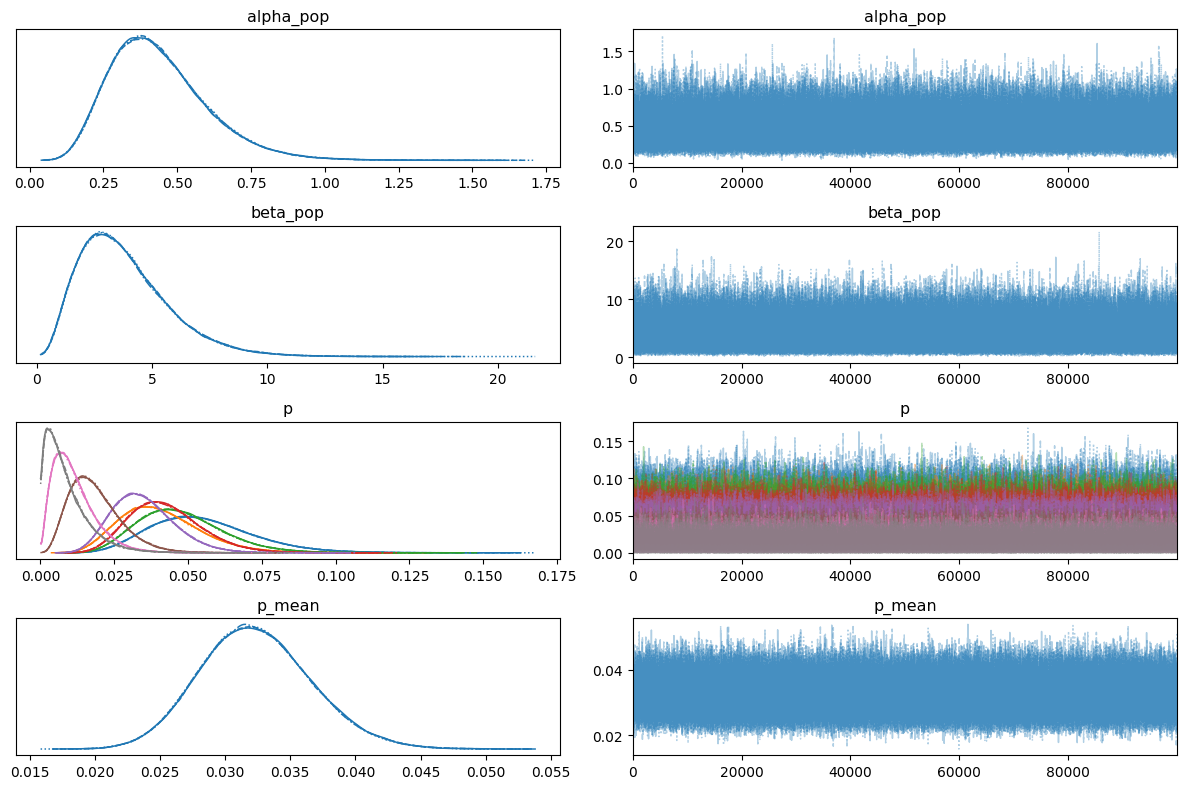

In [15]:
az.plot_trace(trace_CBR)
plt.tight_layout()

In [8]:
alpha_pop = trace_CBR['posterior']['alpha_pop'].values
beta_pop = trace_CBR['posterior']['beta_pop'].values

alpha_pop_mean = np.mean(alpha_pop)
beta_pop_mean = np.mean(beta_pop)

expected_CBR = alpha_pop_mean / (alpha_pop_mean + beta_pop_mean)
expected_SD_CBR = np.sqrt((alpha_pop_mean * beta_pop_mean) / 
                          ((alpha_pop_mean + beta_pop_mean)**2 * 
                           (alpha_pop_mean + beta_pop_mean + 1)))

print('Population level CBR: {:.4f} ± {:.4f}'.format(expected_CBR, expected_SD_CBR))

Population level CBR: 0.1031 ± 0.1329


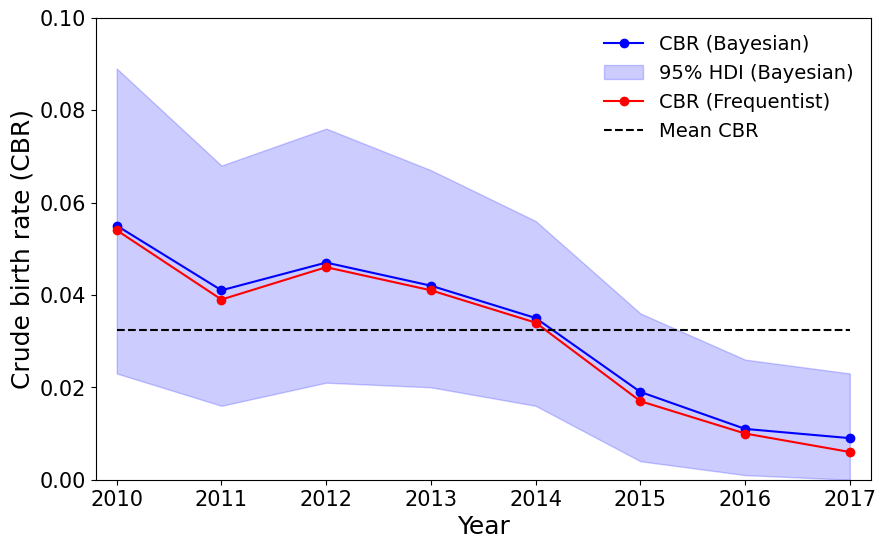

In [ ]:
years = np.arange(2010, 2018)

CBR_df = az.summary(trace_CBR, var_names=["p"], hdi_prob=0.95)
expected_CBR_yearly = CBR_df["mean"].values
lower_CI_CBR_yearly = CBR_df["hdi_2.5%"].values
upper_CI_CBR_yearly = CBR_df["hdi_97.5%"].values

data = {'Year': years, 'CBR': expected_CBR_yearly, 'Lower 95% CI': lower_CI_CBR_yearly, 'Upper 95% CI': upper_CI_CBR_yearly}
df = pd.DataFrame(data)

years = np.arange(2010, 2018)
data = {'Year': years, 'CBR': expected_CBR_yearly, 'Lower 95% CI': lower_CI_CBR_yearly, 'Upper 95% CI': upper_CI_CBR_yearly}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['CBR'], marker='o', linestyle='-', color='blue', label='CBR (Bayesian)')
plt.fill_between(df['Year'], df['Lower 95% CI'], df['Upper 95% CI'], color='blue', alpha=0.2, label='95% HDI (Bayesian)')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Crude birth rate (CBR)', fontsize=18)
plt.ylim(0, 0.1)

years = []
birth_rates = [] # Frequentist approach
plt.plot(years, birth_rates, marker='o', linestyle='-', color='red', label='CBR (Frequentist)')
plt.hlines(expected_CBR_yearly.mean(), xmin=2010, xmax=2017, color='black', linestyles='--', label='Mean CBR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14, frameon=False)

plt.xlim(2009.8, 2017.2)
plt.show()

# Annual Recruitment Rate

In [ ]:
number_of_individuals_ARR = np.array([])
number_of_calves_at_age_1 = np.array([])

with pm.Model() as model_ARR:
    # Hyperpriors for population-level parameters
    alpha_pop = pm.Gamma('alpha_pop', 1, 1)
    beta_pop = pm.Gamma('beta_pop', 1, 1)

    p = pm.Beta('p', alpha=alpha_pop, beta=beta_pop, shape=len(number_of_individuals_ARR))
    p_mean = pm.Deterministic('p_mean', p.mean())

    # Likelihood
    y = pm.Binomial('y', n=number_of_individuals_ARR, p=p, observed=number_of_calves_at_age_1)
    trace_ARR = pm.sample(100000, tune=5000, n_init=10000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_pop, beta_pop, p]


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 137 seconds.


In [32]:
with model_ARR:
    ARR_summary = pm.summary(trace_ARR, hdi_prob=0.95)

In [33]:
ARR_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_pop,0.365,0.143,0.117,0.649,0.000,0.000,433239.0,315681.0,1.0
beta_pop,3.385,1.858,0.456,7.023,0.003,0.002,463078.0,294097.0,1.0
p[0],0.031,0.012,0.010,0.054,0.000,0.000,517537.0,265513.0,1.0
p[1],0.024,0.010,0.006,0.045,0.000,0.000,493926.0,253346.0,1.0
p[2],0.027,0.010,0.010,0.047,0.000,0.000,543558.0,274262.0,1.0
p[3],0.021,0.008,0.007,0.038,0.000,0.000,491170.0,257472.0,1.0
p[4],0.010,0.006,0.000,0.023,0.000,0.000,474423.0,244359.0,1.0
p[5],0.016,0.009,0.002,0.033,0.000,0.000,503181.0,255499.0,1.0
p[6],0.008,0.007,0.000,0.023,0.000,0.000,418136.0,234319.0,1.0
p_mean,0.020,0.003,0.013,0.027,0.000,0.000,535779.0,326943.0,1.0


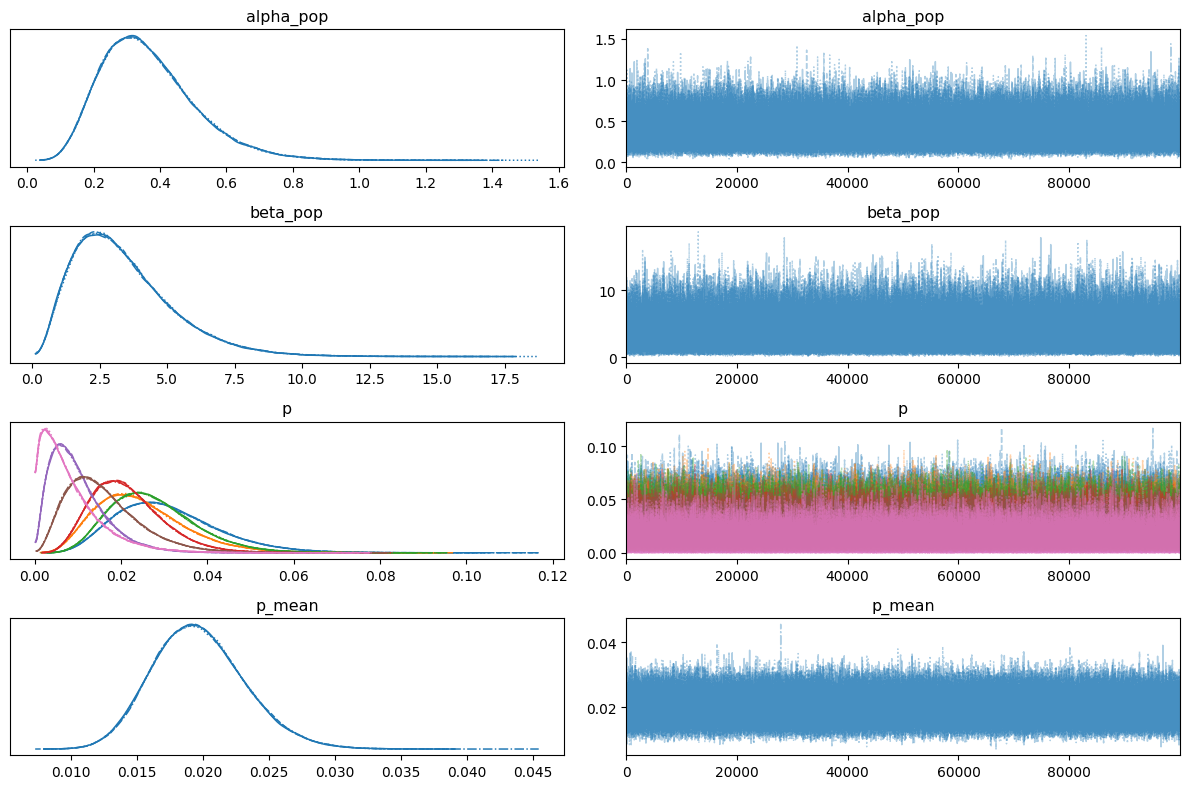

In [34]:
az.plot_trace(trace_ARR)
plt.tight_layout()

In [36]:
alpha_pop = trace_ARR['posterior']['alpha_pop'].values
beta_pop = trace_ARR['posterior']['beta_pop'].values

alpha_pop_mean = np.mean(alpha_pop)
beta_pop_mean = np.mean(beta_pop)

expected_ARR = alpha_pop_mean / (alpha_pop_mean + beta_pop_mean)
expected_SD_ARR = np.sqrt((alpha_pop_mean * beta_pop_mean) / 
                          ((alpha_pop_mean + beta_pop_mean)**2 * 
                           (alpha_pop_mean + beta_pop_mean + 1)))

print('Population level ARR: {:.4f} ± {:.4f}'.format(expected_ARR, expected_SD_ARR))

Population level ARR: 0.0972 ± 0.1359


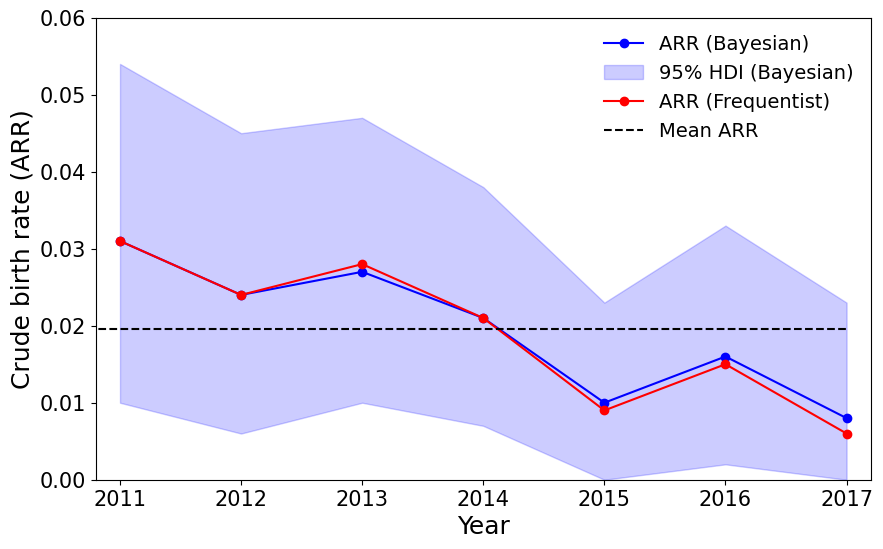

In [ ]:
years = np.arange(2011, 2018)
summary_df = az.summary(trace_ARR, var_names=["p"], hdi_prob=0.95)
expected_ARR_yearly = summary_df["mean"].values
lower_CI_ARR_yearly = summary_df["hdi_2.5%"].values
upper_CI_ARR_yearly = summary_df["hdi_97.5%"].values

data = {'Year': years, 'ARR': expected_ARR_yearly, 'Lower 95% CI': lower_CI_ARR_yearly, 'Upper 95% CI': upper_CI_ARR_yearly}
ARR_df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(ARR_df['Year'], ARR_df['ARR'], marker='o', linestyle='-', color='blue', label='ARR (Bayesian)')
plt.fill_between(ARR_df['Year'], ARR_df['Lower 95% CI'], ARR_df['Upper 95% CI'], color='blue', alpha=0.2, label='95% HDI (Bayesian)')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Crude birth rate (ARR)', fontsize=18)
plt.ylim(0, 0.1)

years = []
birth_rates = [] # Frequentist approach
plt.plot(years, birth_rates, marker='o', linestyle='-', color='red', label='ARR (Frequentist)')
plt.hlines(expected_ARR_yearly.mean(), xmin=2010, xmax=2017, color='black', linestyles='--', label='Mean ARR')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14, frameon=False)

plt.ylim(0, 0.06)
plt.xlim(2010.8, 2017.2)
plt.show()

# OLS Model

In [ ]:
# CBR Frequentist Pre-construction
years = []
birth_rates = []

df = pd.DataFrame({
    'Year': years,
    'BirthRate': birth_rates
})

df['Intercept'] = 1

X = df[['Intercept', 'Year']] 
y = df['BirthRate']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BirthRate   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                 -0.432
Method:                 Least Squares   F-statistic:                    0.3967
Date:                Mon, 27 May 2024   Prob (F-statistic):              0.642
Time:                        00:45:53   Log-Likelihood:                 11.529
No. Observations:                   3   AIC:                            -19.06
Df Residuals:                       1   BIC:                            -20.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0903     12.772      0.633      0.6

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
# CBR Frequentist During-Construction
years = []
birth_rates = []

df = pd.DataFrame({
    'Year': years,
    'BirthRate': birth_rates
})

df['Intercept'] = 1

X = df[['Intercept', 'Year']] 
y = df['BirthRate']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BirthRate   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     58.13
Date:                Mon, 27 May 2024   Prob (F-statistic):            0.00468
Time:                        00:46:41   Log-Likelihood:                 21.918
No. Observations:                   5   AIC:                            -39.84
Df Residuals:                       3   BIC:                            -40.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.9626      2.484      7.633      0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [48]:
years = np.arange(2010, 2018)
data = {'Year': years, 'CBR': CBR_df['mean'], 'Lower 95% CI': CBR_df['hdi_2.5%'], 'Upper 95% CI': CBR_df['hdi_2.5%']}
df = pd.DataFrame(data)

In [51]:
# CBR Bayesian Pre-Construction
df_pre = df[df['Year']<=2012]
df_pre['Intercept'] = 1
X = df_pre[['Intercept', 'Year']] 
y = df_pre['CBR']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CBR   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                 -0.351
Method:                 Least Squares   F-statistic:                    0.4800
Date:                Mon, 27 May 2024   Prob (F-statistic):              0.614
Time:                        00:49:20   Log-Likelihood:                 11.815
No. Observations:                   3   AIC:                            -19.63
Df Residuals:                       1   BIC:                            -21.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0917     11.611      0.697      0.6

/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_83065/2709404169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['Intercept'] = 1
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [52]:
# CBR Bayesian During-Construction
df_pre = df[df['Year']>2012]
df_pre['Intercept'] = 1
X = df_pre[['Intercept', 'Year']] 
y = df_pre['CBR']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CBR   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     47.83
Date:                Mon, 27 May 2024   Prob (F-statistic):            0.00620
Time:                        00:49:41   Log-Likelihood:                 21.648
No. Observations:                   5   AIC:                            -39.30
Df Residuals:                       3   BIC:                            -40.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1582      2.622      6.925      0.0

/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_83065/3181970101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['Intercept'] = 1
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
# ARR Frequentist Pre-Construction
years = []
birth_rates = []

df = pd.DataFrame({
    'Year': years,
    'BirthRate': birth_rates
})

df['Intercept'] = 1

X = df[['Intercept', 'Year']] 
y = df['BirthRate']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BirthRate   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                 -0.635
Method:                 Least Squares   F-statistic:                    0.2231
Date:                Mon, 27 May 2024   Prob (F-statistic):              0.719
Time:                        00:52:05   Log-Likelihood:                 13.608
No. Observations:                   3   AIC:                            -23.22
Df Residuals:                       1   BIC:                            -25.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0457      6.389      0.477      0.7

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
# ARR Frequentist During Construction
years = []
birth_rates = []

df = pd.DataFrame({
    'Year': years,
    'BirthRate': birth_rates
})

df['Intercept'] = 1

X = df[['Intercept', 'Year']] 
y = df['BirthRate']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BirthRate   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     10.90
Date:                Mon, 27 May 2024   Prob (F-statistic):             0.0457
Time:                        00:52:22   Log-Likelihood:                 20.890
No. Observations:                   5   AIC:                            -37.78
Df Residuals:                       3   BIC:                            -38.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0908      3.051      3.307      0.0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [57]:
# ARR Bayesian Pre-Construction
df_pre = ARR_df[ARR_df['Year']<=2013]
df_pre['Intercept'] = 1
X = df_pre[['Intercept', 'Year']] 
y = df_pre['ARR']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ARR   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                 -0.351
Method:                 Least Squares   F-statistic:                    0.4800
Date:                Mon, 27 May 2024   Prob (F-statistic):              0.614
Time:                        00:51:26   Log-Likelihood:                 13.894
No. Observations:                   3   AIC:                            -23.79
Df Residuals:                       1   BIC:                            -25.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0513      5.808      0.698      0.6

/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_83065/4170629453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['Intercept'] = 1
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [58]:
# ARR Bayesian During-Construction
df_pre = ARR_df[ARR_df['Year']>=2013]
df_pre['Intercept'] = 1
X = df_pre[['Intercept', 'Year']] 
y = df_pre['ARR']           

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ARR   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     9.199
Date:                Mon, 27 May 2024   Prob (F-statistic):             0.0562
Time:                        00:51:42   Log-Likelihood:                 21.219
No. Observations:                   5   AIC:                            -38.44
Df Residuals:                       3   BIC:                            -39.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6809      2.857      3.039      0.0

/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_83065/2217342587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['Intercept'] = 1
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# Calving Interval

In [ ]:
# Calving intervals data
intervals = np.array([])

with pm.Model() as model:
    rate = pm.Gamma('rate', alpha=2, beta=1)
    intervals_obs = pm.Exponential('intervals_obs', lam=rate, observed=intervals)
    calf_interval_trace = pm.sample(100000, tune=5000, n_init=10000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate]


Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8909, but should be close to 0.8. Try to increase the number of tuning steps.


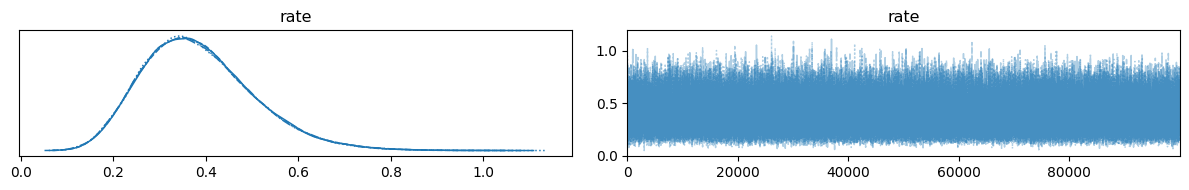

In [62]:
az.plot_trace(calf_interval_trace)
plt.tight_layout()

In [63]:
pm.summary(calf_interval_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,0.384,0.121,0.171,0.611,0.0,0.0,159872.0,208004.0,1.0


# Kepler Meier Estimation

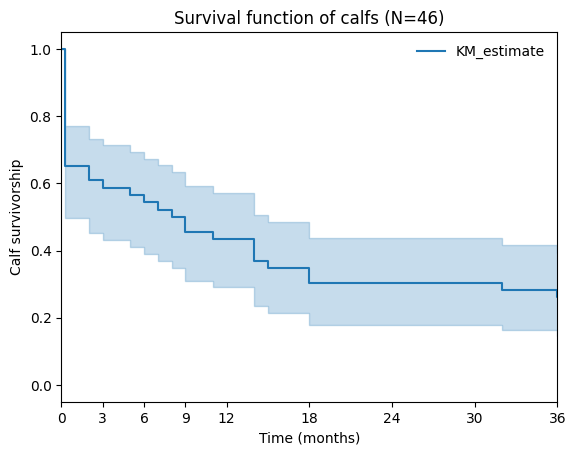

In [ ]:
last_seen_months = ([])
censor_46 = ([])
kmf = KaplanMeierFitter()

T = last_seen_months
E = np.ones(len(last_seen_months))

kmf.fit(T, event_observed=E) 

kmf.plot_survival_function()
plt.title('Survival function of calfs (N=46)')
plt.xlabel('Time (months)')
plt.ylabel('Calf survivorship')
plt.xticks([0, 3, 6, 9, 12, 18, 24, 30, 36])
plt.xlim(0, 36)
plt.legend(frameon=False)

plt.show()
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)